In [1]:
pip install DeepXDE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from IPython.display import display
import tensorflow as tf
dde.config.set_default_float('float64')


x_l = -25
x_r = 25
t_lower = 0
t_upper = 0.1

x = np.linspace(x_l, x_r, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_l, x_r)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


k = 1
χ = 0.1
a = 0.1
x_0 = 0
θ_0 = 0

a1 = 0.1
a2 = 0.1
a4 = 0.1
a6 = 0.1

b1 = 2.0

A1 = np.sqrt((2 * χ / b1) * (a2 - 6 * a4 * k ** 2 + 12 * a4 * k + 10 * a4 + 75 * a6 * k ** 4 + 150 * a6 * k ** 2 + 91 * a6))
C0 = a1 + 2 * a2 * k + 8 * a4 * k ** 3 + 96 * a6 * k ** 5
ω = a1 * k + a2 * k ** 2 - a2 + 3 * a4 * k ** 4 - 6 * a4 * k ** 2 - a4 + 35 * a6 * k ** 6 - 75 * a6 * k ** 4 - 15 * a6 * k ** 2 - a6

a3 = -4 * a4 * k - 40 * a6 * k ** 3
a5 = -6 * a6 * k

b2 = - (24 * a4 * χ ** 2 + 360 * a6 * χ ** 2 * k ** 2 + 840 * a6 * χ ** 2) / A1 ** 4
b3 = 720 * a6 * χ ** 3 / A1 ** 6


def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    u_xxx = dde.grad.jacobian(u_xx, x, j=0)
    v_xxx = dde.grad.jacobian(v_xx, x, j=0)

    u_xxxx = dde.grad.jacobian(u_xxx, x, j=0)
    v_xxxx = dde.grad.jacobian(v_xxx, x, j=0)

    u_xxxxx = dde.grad.jacobian(u_xxxx, x, j=0)
    v_xxxxx = dde.grad.jacobian(v_xxxx, x, j=0)

    u_xxxxxx = dde.grad.jacobian(u_xxxxx, x, j=0)
    v_xxxxxx = dde.grad.jacobian(v_xxxxx, x, j=0)

    f_u = -v_t - a1 * v_x + a2 * u_xx - a3 * v_xxx + a4 * u_xxxx - a5 * v_xxxxx + a6 * u_xxxxxx + u * (b1 * (u ** 2 + v ** 2) + b2 * (u ** 2 + v ** 2) ** 2 + b3 * (u ** 2 + v ** 2) ** 3)
    f_v = u_t + a1 * u_x + a2 * v_xx + a3 * u_xxx + a4 * v_xxxx + a5 * u_xxxxx + a6 * v_xxxxxx + v * (b1 * (u ** 2 + v ** 2) + b2 * (u ** 2 + v ** 2) ** 2 + b3 * (u ** 2 + v ** 2) ** 3)

    return [f_u, f_v]


bc_u_0 = dde.icbc.DirichletBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=0
)
bc_v_0 = dde.icbc.DirichletBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=1
)


bc_u_1 = dde.icbc.NeumannBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=0
)
bc_v_1 = dde.icbc.NeumannBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=1
)


bc_u_2 = dde.icbc.OperatorBC(
    geomtime, lambda x, u, _: dde.grad.hessian(u, x, i=0, j=0),
    lambda _, on_boundary: on_boundary
)
bc_v_2 = dde.icbc.OperatorBC(
    geomtime, lambda x, v, _: dde.grad.hessian(v, x, i=0, j=0),
    lambda _, on_boundary: on_boundary
)


def init_cond_u(x):
    exp = np.exp(np.float128(x[:, 0:1] - x_0))

    return np.cos(k * x[:, 0:1] + θ_0) * (A1 / (a * exp + χ / (4 * a * exp)))


def init_cond_v(x):
    exp = np.exp(np.float128(x[:, 0:1] - x_0))

    return np.sin(k * x[:, 0:1] + θ_0) * (A1 / (a * exp + χ / (4 * a * exp)))


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_u_2, bc_v_0, bc_v_1, bc_v_2, ic_u, ic_v],
    num_domain=30000,
    num_boundary=1000,
    num_initial=3000,
    train_distribution="pseudo",
)

net = dde.nn.FNN([2] + [200] + [2], "sin", "Glorot normal")

model = dde.Model(data, net)

model.compile("adam", lr=1.1e-02, loss="MSE", loss_weights=[1, 1, 1000, 1000, 1, 1000, 1000, 1, 10000, 10000])
model.train(iterations=30000, display_every=1000)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Set the default float type to float64
Compiling model...
Building feed-forward neural network...
'build' took 0.114446 s

'compile' took 2.796398 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [6.19e+01, 8.19e+00, 9.21e+02, 9.68e+00, 4.48e-05, 4.54e+02, 4.02e+00, 4.48e-05, 3.07e+04, 8.38e+03]    [6.19e+01, 8.19e+00, 9.21e+02, 9.68e+00, 4.48e-05, 4.54e+02, 4.02e+00, 4.48e-05, 3.07e+04, 8.38e+03]    []  
1000      [2.73e+01, 2.20e+01, 2.53e+00, 9.78e+00, 8.90e-01, 5.64e-01, 9.18e+00, 8.90e-01, 4.21e+02, 7.50e+02]    [2.73e+01, 2.20e+01, 2.53e+00, 9.78e+00, 8.90e-01, 5.64e-01, 9.18e+00, 8.90e-01, 4.21e+02, 7.50e+02]    []  
2000      [1.71e+01, 1.03e+01, 6.45e-01, 1.15e-01, 1.02e+00, 1.85e-01, 5.78e-01, 1.02e+00, 1.81e+02, 1.46e+02]    [1.71e+01, 1.03e+01, 6.45e-01, 1.15e-01, 1

(<deepxde.model.LossHistory at 0x7bcaf8804610>,
 <deepxde.model.TrainState at 0x7bcaf88043a0>)

In [3]:
model.compile("L-BFGS", loss_weights=[1, 1, 1000, 1000, 1, 1000, 1000, 1, 10000, 10000])
model.train(iterations=10000, display_every=1000)

Compiling model...
'compile' took 0.991670 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
30000     [1.08e+00, 8.10e-01, 1.37e-02, 4.85e-01, 3.48e-02, 2.01e-02, 1.46e-01, 3.48e-02, 6.05e+00, 5.18e+00]    [1.08e+00, 8.10e-01, 1.37e-02, 4.85e-01, 3.48e-02, 2.01e-02, 1.46e-01, 3.48e-02, 6.05e+00, 5.18e+00]    []  
30032     [1.08e+00, 8.10e-01, 1.37e-02, 4.85e-01, 3.48e-02, 2.01e-02, 1.46e-01, 3.48e-02, 6.05e+00, 5.18e+00]    [1.08e+00, 8.10e-01, 1.37e-02, 4.85e-01, 3.48e-02, 2.01e-02, 1.46e-01, 3.48e-02, 6.05e+00, 5.18e+00]    []  

Best model at step 29000:
  train loss: 1.35e+01
  test loss: 1.35e+01
  test metric: []

'train' took 11.795410 s



(<deepxde.model.LossHistory at 0x7bcaf8804610>,
 <deepxde.model.TrainState at 0x7bcaf88043a0>)

In [20]:
x_l = -50
x_r = 50
t_lower = 0
t_upper = 1

x = np.linspace(x_l, x_r, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

prediction = model.predict(X_star)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

q = np.sqrt(u ** 2 + v ** 2)

def u_exact(x, t):
    return np.cos(k * x - ω * t + θ_0) * (A1 / (a * np.exp(x - C0 * t - x_0) + χ * np.exp(-(x - C0 * t - x_0)) / (4 * a)))


def v_exact(x, t):
    return np.sin(k * x - ω * t + θ_0) * (A1 / (a * np.exp(x - C0 * t - x_0) + χ * np.exp(-(x - C0 * t - x_0)) / (4 * a)))


def q_exact(x, t):
    return A1 / (a * np.exp(x - C0 * t - x_0) + χ * np.exp(-(x - C0 * t - x_0)) / (4 * a))


data_ = {'x': X.flatten(), 't': T.flatten(), 'pred_u': u.flatten(), 'pred_v': v.flatten(), 'pred_h': q.flatten(),
        'true_u': u_exact(X, T).flatten(), 'true_v': v_exact(X, T).flatten(), 'true_h': q_exact(X, T).flatten()
         }

df = pd.DataFrame(data_)
df.to_orc('my_data.orc')
display(df)

,x,t,pred_u,pred_v,pred_h,true_u,true_v,true_h
0,-50.000000,0.0,-0.099974,0.341115,0.355463,1.358533e-21,3.693858e-22,1.407855e-21
1,-49.607843,0.0,0.042030,0.338357,0.340957,1.649249e-21,1.273763e-21,2.083865e-21
2,-49.215686,0.0,0.179086,0.329787,0.375275,1.535290e-21,2.675232e-21,3.084474e-21
3,-48.823529,0.0,0.281005,0.302731,0.413049,5.866137e-22,4.527703e-21,4.565546e-21
4,-48.431373,0.0,0.345851,0.249672,0.426555,-1.758925e-21,6.524862e-21,6.757783e-21
...,...,...,...,...,...,...,...,...
51451,48.431373,1.0,-0.731401,0.443429,0.855323,-4.514160e-16,-5.981440e-16,7.493681e-16
51452,48.823529,1.0,-0.845359,0.634892,1.057222,-1.273823e-16,-4.899845e-16,5.062717e-16
51453,49.215686,1.0,-0.831653,0.721561,1.101043,4.698859e-17,-3.387932e-16,3.420362e-16
51454,49.607843,1.0,-0.685005,0.748014,1.014276,1.168125e-16,-1.993799e-16,2.310790e-16


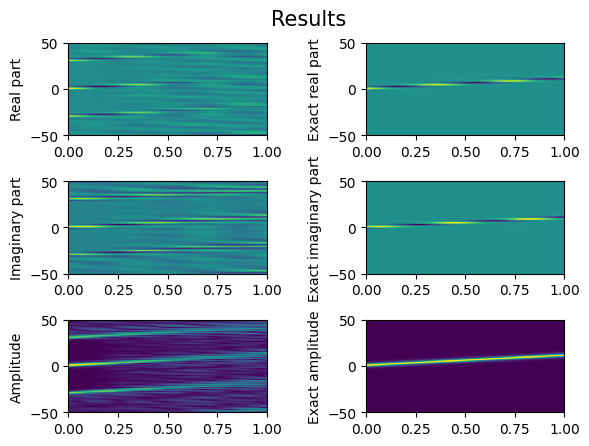

In [21]:
fig, ax = plt.subplots(3, 2)

plt.suptitle("Results", fontsize=15, x=0.5, y=0.95)

ax[0, 0].set_ylabel("Real part")
ax[0, 0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[1, 0].set_ylabel("Imaginary part")
ax[1, 0].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

ax[0, 1].set_ylabel("Exact real part")
ax[0, 1].imshow(
    u_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[1, 1].set_ylabel("Exact imaginary part")
ax[1, 1].imshow(
    v_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[2, 1].set_ylabel("Exact amplitude")
ax[2, 1].imshow(
    q_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()